
#  Bike Sharing Predictions in Washington D.C.

### Leandro Handal Baracatt 
#### MSc Management | MSc Business Analytics & Big Data	
#### <lhandalb@gmail.com>
  

---

# Importing Packages and Libraries <a class="anchor" id="1"></a>

In [3]:
import s3fs
import numpy as np
import pandas as pd
from dask.distributed import Client
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from sklearn.externals import joblib
import matplotlib as plt
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline
from dask_ml.preprocessing import MinMaxScaler, DummyEncoder, StandardScaler
from scikitplot.metrics import plot_calibration_curve
from scikitplot.plotters import plot_learning_curve
from scikitplot.estimators import plot_feature_importances
from sklearn.linear_model import LinearRegression, Ridge
#from dask_ml.linear_model import LinearRegression
from dask_ml.xgboost import XGBRegressor
from dask_ml.metrics import accuracy_score
from dask_ml.datasets import make_regression
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from dask_ml.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import dask_searchcv as dcv
from vecstack import stacking
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import itertools
from pylab import rcParams
import statsmodels.api as sm
import sys

if not sys.warnoptions:
    import warnings

    warnings.simplefilter("ignore")

In [4]:
client = Client(n_workers=8, memory_limit='16GB')
client

Client Scheduler: tcp://127.0.0.1:57049,Cluster Workers: 8 Cores: 8 Memory: 128.00 GB


# Reading the Data<a class="anchor" id="2"></a>

In [5]:
day_url = "https://s3.us-east-2.amazonaws.com/leandrohandal/bike_share/day.csv"
hour_url = "https://s3.us-east-2.amazonaws.com/leandrohandal/bike_share/hour.csv"

In [6]:
day = dd.read_csv(day_url, parse_dates=["dteday"]).set_index('instant')
hour = dd.read_csv(hour_url, parse_dates=["dteday"]).set_index('instant')

In [7]:
day.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [8]:
hour.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [9]:
hour.dtypes

dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

   There are 0 null values in the Hour dataset.           There are 0 null values in the Day dataset.


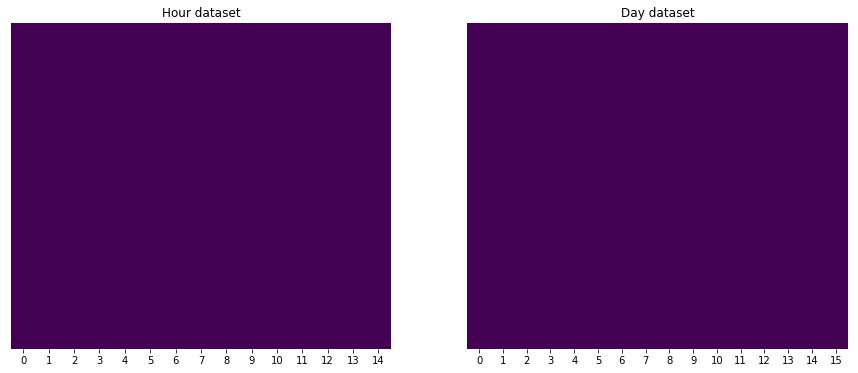

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
sns.heatmap(
    day.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax1
).set_title("Hour dataset")
sns.heatmap(
    hour.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax2
).set_title("Day dataset")

print(
    "   There are {} null values in the Hour dataset.           There are {} null values in the Day dataset.".format(
        hour.isnull().sum().sum().compute(), day.isnull().sum().sum().compute()
    )
)